# March Mashine Learning Mania 2017
The objective is to predict the results of the NCAA tournament for the year 2017. For all possible matchups that can occur a predicted win probability is computed for the team with lower teamID to win. Then the total score for the competition is computed using the Log_Loss function:
$$ {\rm Log\_Loss} = -\frac{1}{n} \sum_{i=1}^n \left(y_i \log \hat{y}_i + (1-y_i)\log( 1-\hat{y}_i) \right) $$
Here $y_i$ is the actual outcome of game $i$ (i.e., equal to either $0$ or $1$) and $\hat{y}_i$ is the predicted outcome. A perfect score is zero.

## Setup
Some preliminary code to import the packages we will need and make the plots look nice.

In [172]:
%matplotlib inline 
import pandas as pd
import numpy as np
#import scipy.stats as stats
import matplotlib.pyplot as plt

from IPython.display import display #for displaying multiple outputs from a single cell


import sklearn
import sklearn.neural_network
import sklearn.model_selection
import sklearn.decomposition
import sklearn.neighbors
import sklearn.metrics

#nice defaults for matplotlib
from matplotlib import rcParams

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

## Import Data
Historical data we use to build our model.

In [173]:
teams = pd.read_csv('./Teams.csv')
#seasons = pd.read_csv('./Seasons.csv')
#results_compact = pd.read_csv('./RegularSeasonCompactResults.csv')
results_detailed = pd.read_csv('./RegularSeasonDetailedResults.csv')
#tourn_results_compact = pd.read_csv('./TourneyCompactResults.csv')
tourn_results_detailed = pd.read_csv('./TourneyDetailedResults.csv')
tourn_seeds = pd.read_csv('./TourneySeeds.csv')
tourn_slots = pd.read_csv('./TourneySlots.csv')
sample = pd.read_csv('./sample_submission.csv')

## Neural Net Model

Our model will be based on efficiency scores, which are totals divided by attempts per game. We will add the relevant columns to the results_detailed dataframe.

In [174]:
#Field Goals
results_detailed['Wfge'] = results_detailed['Wfgm']/results_detailed['Wfga']
results_detailed['Lfge'] = results_detailed['Lfgm']/results_detailed['Lfga']
#Three-pointers
results_detailed['Wfge3'] = results_detailed['Wfgm3']/results_detailed['Wfga3']
results_detailed['Lfge3'] = results_detailed['Lfgm3']/results_detailed['Lfga3']
#Free Throws
results_detailed['Wfte'] = results_detailed['Wftm']/results_detailed['Wfta']
results_detailed['Lfte'] = results_detailed['Lftm']/results_detailed['Lfta']

results_detailed.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lto,Lstl,Lblk,Lpf,Wfge,Lfge,Wfge3,Lfge3,Wfte,Lfte
0,2003,10,1104,68,1328,62,N,0,27,58,...,18,9,2,20,0.465517,0.415094,0.214286,0.200000,0.611111,0.727273
1,2003,10,1272,70,1393,63,N,0,26,62,...,12,8,6,16,0.419355,0.358209,0.400000,0.250000,0.526316,0.450000
2,2003,11,1266,73,1437,61,N,0,24,58,...,12,2,5,23,0.413793,0.301370,0.444444,0.115385,0.586207,0.608696
3,2003,11,1296,56,1457,50,N,0,18,38,...,19,4,3,23,0.473684,0.367347,0.333333,0.272727,0.548387,0.533333
4,2003,11,1400,77,1208,71,N,0,30,61,...,10,7,1,14,0.491803,0.387097,0.428571,0.375000,0.846154,0.629630


Now we define a few functions which will compile statistics for us.

-team_stats takes as input a team_ID and (optionally) a season and outputs all of the stastistics for that team (for that season), game by game.

-matchup_stats takes as input two team_IDs and a season and outputs the mean stats of each of those two teams in that season.

-tourn_stats takes as input a season and outputs all of the matchup stats for each game played in that tournament, together with a record of which team won the game. Also included are the seed numbers for each team.

These three functions build on each other, and the output of tourn_stats for a range of seasons will serve as the training set for our model.

In [340]:
#function which outpouts a dataframe with the statistics of a given team and (optionally) a specific season
def team_stats(team_ID, Season = 0):
    #drop the stats we won't use
    X = results_detailed.drop(['Daynum', 'Numot', 'Wloc', 'Wfgm' ,'Wfga', 'Wfgm3', 'Wfga3', 'Wftm',\
                          'Wfta','Lfgm' ,'Lfga', 'Lfgm3', 'Lfga3', 'Lftm',\
                          'Lfta'], axis = 1)
    
    if Season > 0:
        X = X[X['Season'] == Season]
        
        
    X = X.drop('Season',axis=1)
    
    #Collect the stats for all games the team won
    X_W = X[(X.Wteam == team_ID)].drop(['Wteam', 'Lteam', 'Lfge',
                                    'Lfge3','Lfte','Lto','Lblk','Lstl','Lpf','Last', 'Lscore', 'Ldr','Lor'], axis=1)
    X_W.rename(columns = {'Wfge':'fge', 'Wfge3':'fge3','Wfte':'fte','Wto':'to','Wblk':'blk',\
                'Wstl':'stl','Wpf':'pf','Wast':'ast','Wscore':'score', 'Wdr':
                          'dr','Wor':'or'}, inplace = True)
    X_W['Win'] = 1
    
    #Colleche stats for all games the team lost
    X_L = X[(X.Lteam == team_ID)].drop(['Wteam', 'Lteam','Wfge',
                                    'Wfge3','Wfte','Wto','Wblk','Wstl','Wpf','Wast','Wscore', 'Wdr','Wor'], axis=1)
    X_L.rename(columns = {'Lfge':'fge', 'Lfge3':'fge3','Lfte':'fte','Lto':'to','Lblk':'blk',\
                'Lstl':'stl','Lpf':'pf','Last':'ast','Lscore':'score', 'Ldr':
                          'dr','Lor':'or' }, inplace = True)
    X_L['Win'] = 0

    #Combine win stats with loss stats and return
    return pd.concat([X_W, X_L])

In [341]:
#function that outputs the mean season stats for a pair of teams (specified by ID) and a given season
def matchup_stats(team_1, team_2, season):
    A = min(team_1, team_2)
    B = max(team_1, team_2)
    
    A_stats = team_stats(A, season)
    B_stats = team_stats(B, season)
    
    A_stats.rename(columns = {'fge' : 'Afge', 'fge3':'Afge3','fte':'Afte','to':'Ato','blk':'Ablk',\
                'stl':'Astl','pf':'Apf','ast':'Aast','score':'Ascore', 'dr':
                          'Adr','or':'Aor','Win':'Awrate' }, inplace = True)
    B_stats.rename(columns = {'fge' : 'Bfge', 'fge3':'Bfge3','fte':'Bfte','to':'Bto','blk':'Bblk',\
                'stl':'Bstl','pf':'Bpf','ast':'Bast','score':'Bscore', 'dr':
                          'Bdr','or':'Bor','Win':'Bwrate' }, inplace = True)
    
    return pd.concat([A_stats.mean(), B_stats.mean()])

In [342]:
#function to compile statistics for all matchups in a given tournament
def tourn_stats(season):
    
    tourn = pd.DataFrame(columns = ['Afge','Afge3','Afte','Ato','Ablk',\
                'Astl','Apf','Aast','Ascore', 'Adr','Aor','Awrate','Bfge','Bfge3','Bfte','Bto','Bblk',\
                'Bstl','Bpf','Bast','Bscore', 'Bdr','Bor','Bwrate','Aseed','Bseed', 'Awin'] )
    
    results = tourn_results_detailed[tourn_results_detailed['Season'] == season]
    for i in results.index:
        A = min(results.ix[i].Wteam,results.ix[i].Lteam)
        B = max(results.ix[i].Wteam,results.ix[i].Lteam)

        game_stats = pd.DataFrame(matchup_stats(A,B,season)).T
        
        game_stats['Aseed'] = int(tourn_seeds[(tourn_seeds.Season == season) &\
                                              (tourn_seeds.Team == A) ].Seed.values[0][1:3])
        game_stats['Bseed'] = int(tourn_seeds[(tourn_seeds.Season == season) &\
                                              (tourn_seeds.Team == B) ].Seed.values[0][1:3])
    
        if A == results.ix[i].Wteam:
            game_stats['Awin'] = 1
        else:
            game_stats['Awin'] = 0 
        
        tourn = pd.concat([tourn, game_stats])
        
    return tourn

Now we compile all of the tourn_stats for a range of seasons to use as the training set for our model

In [415]:
#Compile statistics for all tournaments in a given range of years
all_stats = pd.DataFrame(columns = ['Afge','Afge3','Afte','Ato','Ablk',\
                'Astl','Apf','Aast','Ascore', 'Adr','Aor','Awrate','Bfge','Bfge3','Bfte','Bto','Bblk',\
                'Bstl','Bpf','Bast','Bscore', 'Bdr','Bor','Bwrate','Aseed','Bseed', 'Awin'] )

for year in range(2003, 2012 +1):
    all_stats = pd.concat([all_stats,tourn_stats(year)], ignore_index=True)

all_stats = all_stats[['Afge','Afge3','Afte','Ato','Ablk',\
                'Astl','Apf','Aast','Ascore', 'Adr','Aor','Awrate','Bfge','Bfge3','Bfte','Bto','Bblk',\
                'Bstl','Bpf','Bast','Bscore', 'Bdr','Bor','Bwrate','Aseed','Bseed', 'Awin']]
all_stats.head()

,Afge,Afge3,Afte,Ato,Ablk,Astl,Apf,Aast,Ascore,Adr,...,Bstl,Bpf,Bast,Bscore,Bdr,Bor,Bwrate,Aseed,Bseed,Awin
0,0.448892,0.321414,0.613745,15.233333,2.233333,6.433333,18.300000,14.200000,72.800000,24.800000,...,7.068966,19.103448,13.034483,71.206897,23.172414,12.275862,0.448276,16.0,16.0,0.0
1,0.463563,0.351060,0.701154,14.785714,4.214286,8.464286,17.750000,17.642857,85.214286,27.642857,...,6.862069,15.896552,14.206897,67.793103,25.724138,12.965517,0.655172,1.0,16.0,1.0
2,0.481680,0.328376,0.675667,14.000000,4.241379,5.206897,19.413793,15.551724,75.965517,23.310345,...,7.379310,18.758621,16.620690,74.517241,25.965517,14.068966,0.793103,10.0,7.0,1.0
3,0.506349,0.377481,0.762741,18.241379,4.000000,7.103448,20.965517,15.620690,79.344828,23.275862,...,8.393939,17.272727,16.818182,79.242424,23.181818,10.878788,0.878788,11.0,6.0,1.0
4,0.468741,0.375934,0.688632,14.172414,2.793103,6.551724,17.103448,16.000000,74.482759,24.379310,...,7.766667,18.666667,14.666667,72.400000,22.033333,9.733333,0.600000,8.0,9.0,1.0


This is where we define the model for calculating win probabilities. The model is a neural network with one hidden layer containing 15 nodes.

In [419]:
X = all_stats.drop('Awin',axis=1)
Y = all_stats['Awin']

#standard ordering of the columns
cols = ['Afge','Afge3','Afte','Ato','Ablk','Astl','Apf','Aast','Ascore', \
        'Adr','Aor','Awrate','Bfge','Bfge3','Bfte','Bto','Bblk',\
        'Bstl','Bpf','Bast','Bscore', 'Bdr','Bor','Bwrate','Aseed','Bseed']

X = X[cols]

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

model = sklearn.neural_network.MLPClassifier(activation='logistic',hidden_layer_sizes=(15,))
model.fit(X,Y)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Cross-validation

We cross-validate the model to help estimate errors


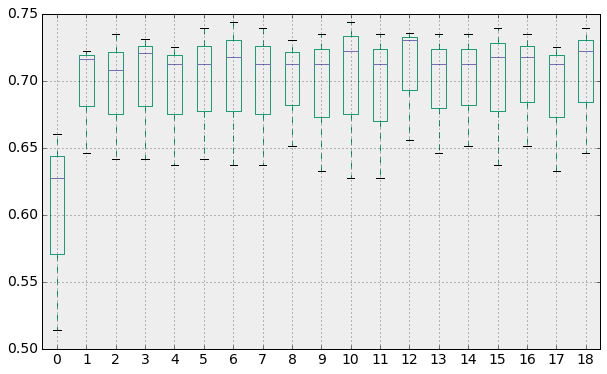

In [417]:
parameters = {'hidden_layer_sizes' : [(i,) for i in range(1,20)]}
grid = sklearn.model_selection.GridSearchCV(model,parameters, cv = 3)
grid.fit(X,Y)
cv = pd.DataFrame(grid.cv_results_)
cv[['split0_test_score','split1_test_score','split2_test_score']].T.boxplot()
plt.show()

In [418]:
grid.best_params_

{'hidden_layer_sizes': (13,)}

## Generate Predictions

This function generates all of the predictions for the possible matchups in a given tournament. The output is formatted according to the Kaggle specifications.

In [345]:
from itertools import combinations

def generate_predictions(Season):
   
    ids = []
    pred = []
    
    matchups = tourn_seeds[tourn_seeds['Season']==Season].Team
    matchups = combinations(matchups, 2)
    
    for n ,l in matchups:
        A = min(n,l)
        B = max(n,l)
        
        match_stats = matchup_stats(A,B,Season)
        
        match_stats['Aseed'] = int(tourn_seeds[(tourn_seeds.Season == Season) &\
                                              (tourn_seeds.Team == A) ].Seed.values[0][1:3])
        match_stats['Bseed'] = int(tourn_seeds[(tourn_seeds.Season == Season) &\
                                              (tourn_seeds.Team == B) ].Seed.values[0][1:3])
        
        match_stats = scaler.transform(match_stats[cols].values.reshape(1,-1))
        
        P = model.predict_proba(match_stats)[0,1]
        
        ids.append('%s_%s_%s' %(Season, A, B))
        pred.append(P)
        
    return ids, pred

In [420]:
preds = pd.DataFrame(columns = ['id','pred'])
for year in range(2013, 2016 +1):
    ids, pred = generate_predictions(year)    
    temp_preds = pd.DataFrame(ids,columns = ['id'])
    temp_preds['pred'] = pred
    preds = pd.concat([preds,temp_preds])
preds.head()

,id,pred
0,2013_1231_1274,0.626697
1,2013_1231_1266,0.633896
2,2013_1231_1393,0.529667
3,2013_1231_1424,0.622914
4,2013_1139_1231,0.386368


In [421]:
loss = 0
for year in range(2013, 2016 +1):
    loss += compute_loss(preds,year)
loss = loss/len(range(2013, 2016 +1))
loss

0.62856731590477888

In [348]:
#preds.to_csv('second_submission.csv', index=False)

## Testing
This function will compute the log loss for a given set of predictions for a tournament from one of the seasons 2003-2016. The predictions are assumed to be in the form of the Kaggle submission file. A baseline value for the loss function is $\log 2 \approx 0.69$, which would be the result if one just flipped a coin for every game.

In [78]:
def compute_loss(predictions, season):
    results = tourn_results_detailed[tourn_results_detailed['Season']== season]
    loss = 0
    for i in results.index:
        A = min(results.ix[i].Wteam,results.ix[i].Lteam)
        B = max(results.ix[i].Wteam,results.ix[i].Lteam)
        if A == results.ix[i].Wteam:
            loss += -np.log(predictions[predictions['id']== '%s_%s_%s' %(season,A,B)].pred.values[0])
        else:
            loss += -np.log(1-predictions[predictions['id']== '%s_%s_%s' %(season,A,B)].pred.values[0])
    return loss/len(results)

The first submission was not very sensible and was mostly an exercise in getting succssfully submittion something. The log loss is worse than random guessing.

In [89]:
test = pd.read_csv('first_submission.csv')
loss = 0
for year in range(2013, 2016 +1):
    loss += compute_loss(test,year)
loss = loss/len(range(2013, 2016 +1))
loss

0.73183285394105946

The second submission is an actual neural net model that compares the teams that are being matched up and also takes into account the tournament seeds.

In [349]:
test = pd.read_csv('second_submission.csv')
loss = 0
for year in range(2013, 2016 +1):
    loss += compute_loss(test,year)
loss = loss/len(range(2013, 2016 +1))
loss

0.58549862096697514